cuda:0


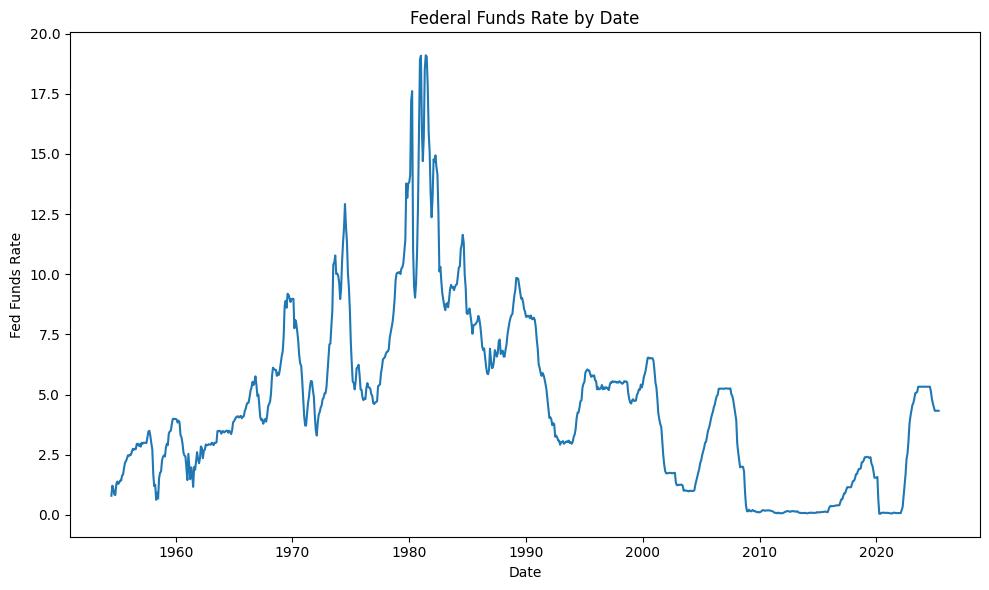

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from docs.untitled import fred_api_key
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np


fred = fr.Fred(fred_api_key)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

"""Interest Rates(Fed Funds Rate) """

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()
data = data.reset_index()
data['Date'] = data['index']
data.drop("index",axis=1,inplace=True)
data.head(10)


plt.figure(figsize=(10,6))
sns.lineplot(x=data['Date'],y=data['Fed Funds Rate'])
plt.title("Federal Funds Rate by Date")
plt.savefig("images/federal-funds-rate-date.png")
plt.tight_layout()
plt.show()


In [2]:

data = data.shift(1)
data.dropna(inplace=True)
training = data.iloc[:,0:1].values



train_split = int(len(training) * .85)
train_data = training[:train_split]
test_data = training[train_split:]
print(train_data.shape)
print(test_data.shape)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length - 1):
        X_ = dataframe[i:(i + seq_length)]
        y_ = dataframe[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 1
X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()





class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

(722, 1)
(128, 1)


C:\Users\katsa\AppData\Local\Temp\ipykernel_14812\1528361119.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_14812\1528361119.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2971; Test RSME: 0.1143
Epoch: 1; train_RSEM: 0.2793; Test RSME: 0.1046
Epoch: 2; train_RSEM: 0.2621; Test RSME: 0.09852
Epoch: 3; train_RSEM: 0.2455; Test RSME: 0.09683
Epoch: 4; train_RSEM: 0.2295; Test RSME: 0.09993
Epoch: 5; train_RSEM: 0.2145; Test RSME: 0.1077
Epoch: 6; train_RSEM: 0.2008; Test RSME: 0.1197
Epoch: 7; train_RSEM: 0.1889; Test RSME: 0.1349
Epoch: 8; train_RSEM: 0.1796; Test RSME: 0.1526
Epoch: 9; train_RSEM: 0.1735; Test RSME: 0.1718
Epoch: 10; train_RSEM: 0.1711; Test RSME: 0.1914
Epoch: 11; train_RSEM: 0.172; Test RSME: 0.2102
Epoch: 12; train_RSEM: 0.1751; Test RSME: 0.2266
Epoch: 13; train_RSEM: 0.1788; Test RSME: 0.2392
Epoch: 14; train_RSEM: 0.1815; Test RSME: 0.2472
Epoch: 15; train_RSEM: 0.1825; Test RSME: 0.2504
Epoch: 16; train_RSEM: 0.1814; Test RSME: 0.2492
Epoch: 17; train_RSEM: 0.1787; Test RSME: 0.2444
Epoch: 18; train_RSEM: 0.1747; Test RSME: 0.2367
Epoch: 19; train_RSEM: 0.1703; Test RSME: 0.227
Epoch: 20; train_RSEM: 0.1659

In [3]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = data.iloc[train_split + seq_length: -1]['Date'].reset_index(drop=True)


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Interest Rate": actual_rescaled.flatten(),
    "Predicted Interest Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

         Date  Actual Interest Rate  Predicted Interest Rate
0  2014-10-01                  0.09                 0.106762
1  2014-11-01                  0.09                 0.106762
2  2014-12-01                  0.12                 0.106762
3  2015-01-01                  0.11                 0.136875
4  2015-02-01                  0.11                 0.126837
5  2015-03-01                  0.11                 0.126837
6  2015-04-01                  0.12                 0.126837
7  2015-05-01                  0.12                 0.136875
8  2015-06-01                  0.13                 0.136875
9  2015-07-01                  0.13                 0.146912
10 2015-08-01                  0.14                 0.146912
11 2015-09-01                  0.14                 0.156949
12 2015-10-01                  0.12                 0.156949
13 2015-11-01                  0.12                 0.136875
14 2015-12-01                  0.24                 0.136875
15 2016-01-01           

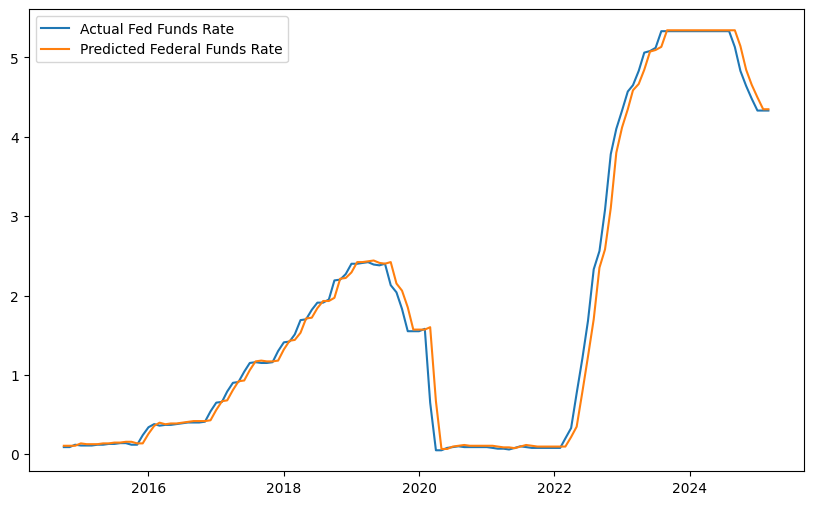

In [4]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Interest Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Interest Rate'],label="Predicted Federal Funds Rate")
plt.legend()
plt.savefig("images/predicted-vs-actual.png")
plt.show()
